In [237]:
#D.B. Marx: 4624475

#In addition to listed libraries, Geopandas and Shapely were also used.


#Pros for Naive Bayes
#Insights of high quality for explicitly defining trends
#Strong real world track record


#Cons for Naive Bayes
#Requires training sites to be referenced and used in masking functions to provide labels. A priori data not always available
#Assumes conditional independence between pairs of features. Naive not to consider potential correlation. As such estimates not considered as precise as trend demarkation



#Mask of landcover layer as shapefile worked better with 60m images than 10m subsets
#Mask of landcover layer created via reprojection to EPSG:32631, crop by extent, points within extent, join attributes by location in QGIS
#Lucky to have CBS mutatiereeks converted from MBTiles to .shp then GEOJSON for this classification from work
#Workflow spits out useful stack of 60m images. See Jupyter repository

#Eight classes chosen to match workflow

import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

In [243]:


import os # we need os to do some basic file operations



sentinal_fp = "../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]
sentinal_band_paths.sort()
sentinal_band_paths

['../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_AOT_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B01_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B02_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B03_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B04_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B05_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B06_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_20200530T105031_B07_60m.jp2',
 '../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/T31UET_2020

TypeError: Image data of dtype <U38 cannot be converted to float

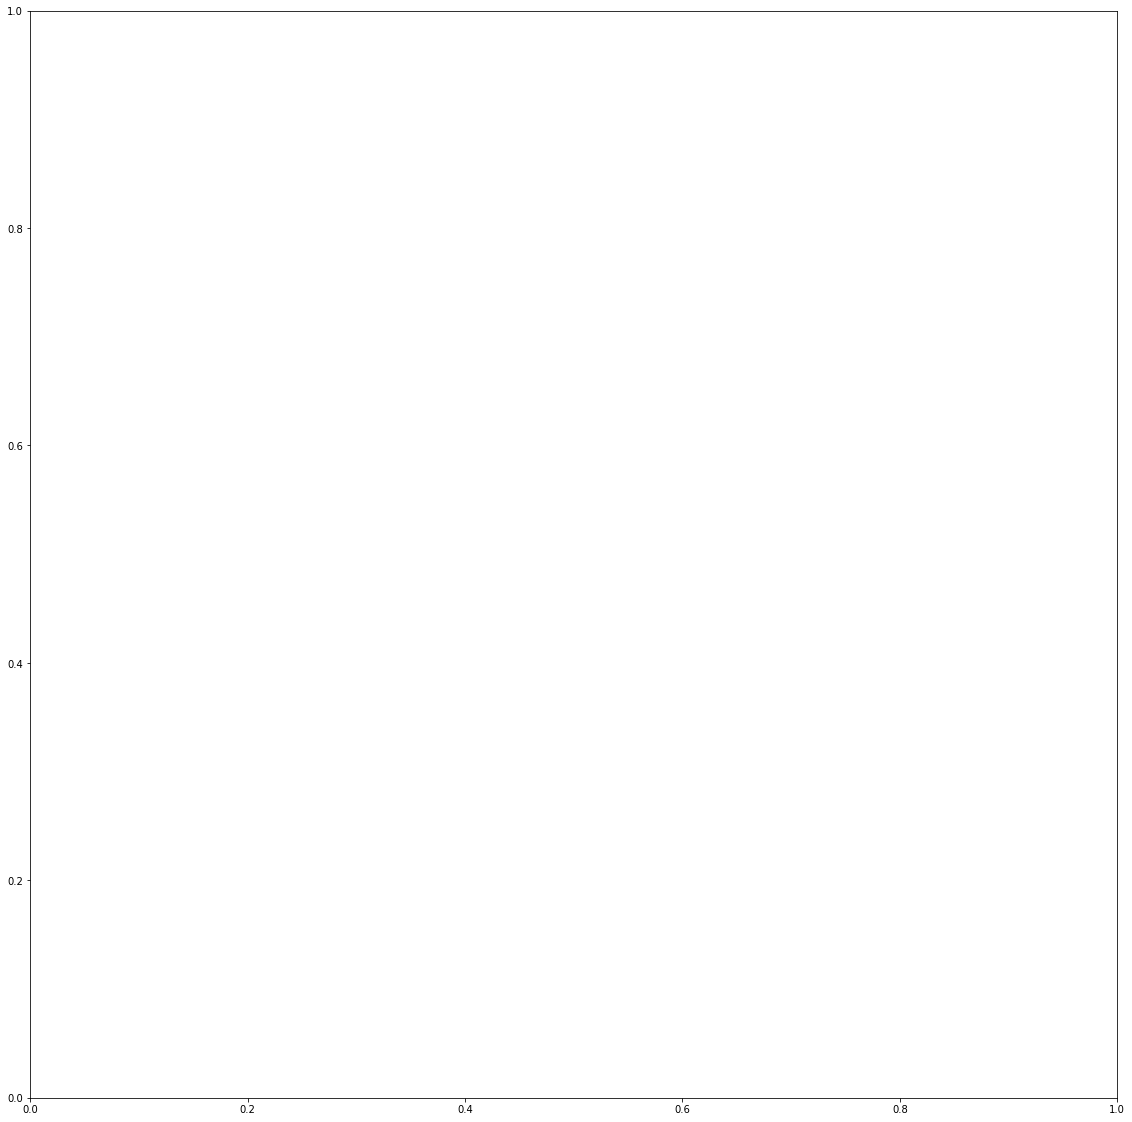

In [269]:


# create a products directory within the data dir which won't be uploaded to Github
img_dir = '../IMG_DATA/products'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))




In [245]:

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

            

In [246]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(1830, 1830)
15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 450, 1150)


<AxesSubplot:>

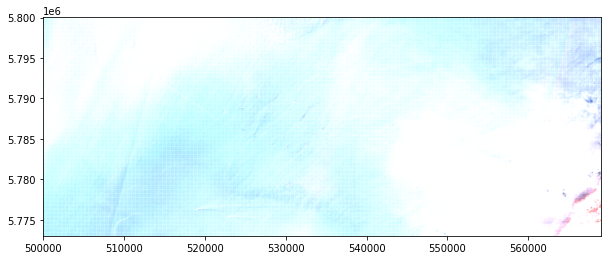

In [247]:





import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = full_dataset.read([4,3,2])[:, 150:600, 250:1400]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords



In [248]:
full_dataset.crs

CRS.from_epsg(32631)

In [249]:

shapefile = gpd.read_file('../my_project_env/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/products/rcr/landuse_60m_reprojected.shp')
shapefile.crs



<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 0°E to 6°E - by country
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [250]:
len(shapefile)

139603

In [251]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((520511.1264488672 5712389.09923749, 520506.494589046 5712522.97030289, 520510.5848385255 5712522.986847505, 520511.1264488672 5712389.09923749))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((520511.1264488672, 5712389.0992374895), (520506.494589046, 5712522.97030289), (520510.5848385255, 5712522.986847505), (520511.1264488672, 5712389.0992374895)),)}]


In [252]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape


(15, 3, 1)

In [263]:
X = np.array([], dtype=np.uint16).reshape(0,15) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 65536, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["use"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))  

AttributeError: 'NoneType' object has no attribute '__geo_interface__'